In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import os
import csv
import matplotlib.pyplot as plt
data_drive = "drive/MyDrive/ebay_data_2023"
from sklearn.feature_extraction.text import CountVectorizer

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(data_drive + "/Train_Tagged_Titles.tsv", sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)
old_tag = train_df.Tag.copy()
train_df

,Record Number,Title,Token,Tag
0,1,Supreme Nike SB Dunk High By any Means Red US1...,Supreme,Modell
1,1,Supreme Nike SB Dunk High By any Means Red US1...,Nike,Marke
2,1,Supreme Nike SB Dunk High By any Means Red US1...,SB,Produktlinie
3,1,Supreme Nike SB Dunk High By any Means Red US1...,Dunk,NaN
4,1,Supreme Nike SB Dunk High By any Means Red US1...,High,Schuhschaft-Typ
...,...,...,...,...
55178,5000,Herren Trekking Schuhe Outdoor Sneaker Sportsc...,Sportschuhe,Produktart
55179,5000,Herren Trekking Schuhe Outdoor Sneaker Sportsc...,Wanderschuh,NaN
55180,5000,Herren Trekking Schuhe Outdoor Sneaker Sportsc...,Big,No Tag
55181,5000,Herren Trekking Schuhe Outdoor Sneaker Sportsc...,Size,No Tag


In [ ]:
tag_groups_train = train_df.groupby("Tag").apply(lambda x: np.unique(x.Token.values))
tag_groups_train

Tag
Abteilung                       [Baby, DAMEN, DAMENSCHUHE, DONNA, Dam, Dame, D...
Aktivität                       [Angeln, Aqua, Athletic, Athletik, Athletisch,...
Akzente                         [Allover, Cut, Fransen, GLITZER, Glanz, Glitte...
Anlass                          [All, Alltags, Beach, Biker, Büro, CAR, CASUAL...
Besonderheiten                  [Air, Air-Cooled, AirCooled, Allover-Design, A...
Charakter                       [Beauty, Bruce, Giannis, Han, Hello, Narut0, P...
Charakter Familie               [DISNEY, Looney, Pokemon, STAR, Sanrio, Star, ...
Dämpfungsgrad                   [Airsoft, Barefoot, Barfuß, Cushion, LUFTPOLST...
EU-Schuhgröße                   [,40, ,44, .35, .36, .36,5, .37, .37,39,40, .3...
Erscheinungsjahr                [05/2006, 1984, 1998, 2001, 2003, 2004, 2005, ...
Farbe                           [AUTUMN, Aero, All, Amber, Anthracite, Anthraz...
Futtermaterial                  [Fell, Fleece, Fur, Kunstfell, Kunstpelz, Lamm...
Gewebeart   

In [ ]:
all_data = pd.read_csv(data_drive + "/Listing_Titles.tsv", sep="\t", dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)
all_data["Record Number"] = all_data["Record Number"].astype(int)

there are 10M rows in all_data

In [ ]:
test_set = all_data.loc[all_data["Record Number"] > 5000, :]
test_set

,Record Number,Title
5000,5001,NIKE FREE RUN 3 SHIELD 5.0 SNEAKERS LAUFSCHUHE...
5001,5002,DAMEN SCHUHE 153351 SNEAKER WEISS 38 NEU
5002,5003,Converse Sneakers Damen Gr . DE 36 Leder grau ...
5003,5004,Adidas Freizeitschuh Gr UK 9
5004,5005,K Swiss Schuhe schwarz Leder größe 41 low snea...
...,...,...
9999995,9999996,Skechers Compulsions Z Strap Damen Schwarz Tur...
9999996,9999997,Neu bogner 199 . Euro neupreis
9999997,9999998,New Balance M670 Herren US 11 Schwarz Tennissc...
9999998,9999999,Pepe Jeans Tinker Pro 73 Edt 20 Sneakers Herre...


In [ ]:
training_text = pd.Series(pd.unique(train_df.Title))
test_text = pd.Series(pd.unique(test_set.Title))

In [ ]:
training_text = training_text.str.lower()
test_text = test_text.str.lower()

# Create a CountVectorizer and fit it on the training text
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(training_text)

# Transform the test text using the same vectorizer
X_test = vectorizer.transform(test_text)

In [ ]:
# Sum the counts of each token in the training and test sets
train_counts = X_train.sum(axis=0)
test_counts = X_test.sum(axis=0)

# Convert the counts to a DataFrame for easier manipulation
token_counts = pd.DataFrame({
    'token': vectorizer.get_feature_names_out(),
    'train_count': train_counts.A[0],
    'test_count': test_counts.A[0]
})

           token  count_difference
4181          gr          -4026878
6604     sneaker          -3024395
6409      schuhe          -2458885
3092       damen          -2220623
5558         neu          -2091574
5590        nike          -1851313
6606    sneakers          -1662765
4433      herren          -1582024
6418     schwarz          -1494235
7141  turnschuhe          -1458881


In [ ]:
# Calculate the total number of tokens in each set
total_tokens_train = token_counts['train_count'].sum()
total_tokens_test = token_counts['test_count'].sum()

# Normalize the token counts by the total number of tokens in each set
token_counts['train_freq'] = token_counts['train_count'] / total_tokens_train
token_counts['test_freq'] = token_counts['test_count'] / total_tokens_test

# Calculate the relative frequency difference between training and test sets
token_counts['freq_difference'] = token_counts['train_freq'] - token_counts['test_freq']

# Sort the DataFrame by frequency difference in ascending order
sorted_token_counts = token_counts.sort_values(by='freq_difference')

# Display the tokens that are least represented in the test set compared to the training set
least_represented_tokens = sorted_token_counts[['token', 'freq_difference']].head(25)
print(least_represented_tokens)

         token  freq_difference
4181        gr        -0.034940
6606  sneakers        -0.010971
5590      nike        -0.009289
886         38        -0.008143
911         40        -0.007734
4240     größe        -0.007727
898         39        -0.007579
7239        us        -0.007159
948         42        -0.006011
857         37        -0.005636
3142        de        -0.005455
7183        uk        -0.005256
3552        eu        -0.005158
6418   schwarz        -0.005077
928         41        -0.004978
963         44        -0.004235
3092     damen        -0.003883
957         43        -0.003853
2852  converse        -0.003682
7023       top        -0.003477
4208      grau        -0.003153
2686    chucks        -0.003022
7290      vans        -0.002765
5238       max        -0.002505
970         45        -0.002500


Negative values means that the token is way more represented in the test set than the training set.
This is by frequency (i.e. proportional to the number of tokens)

In [ ]:
most_represented_tokens = sorted_token_counts[['token', 'freq_difference']].tail(25)
print(most_represented_tokens)

            token  freq_difference
2258        black         0.000979
5756          ovp         0.001017
5117         lyte         0.001029
124           100         0.001038
1904          art         0.001039
5997         puma         0.001043
2065      balance         0.001092
5746      outdoor         0.001123
8             001         0.001145
7516        white         0.001224
5736    originals         0.001411
6258      running         0.001633
1916        asics         0.001751
4079          gel         0.001781
7222       unisex         0.002194
6409       schuhe         0.002241
3691         fila         0.002424
5072          low         0.003002
6701        sport         0.003023
4918   laufschuhe         0.003678
6558     skechers         0.003722
3799     freizeit         0.004151
6711  sportschuhe         0.004874
4433       herren         0.009188
6604      sneaker         0.016903


What this tells us: we already have some domain knowledge.

1.
- Numbers between 38-45 are most Europe sizes that need to be added
- No harm in adding more "EU", "UK", "US" so long as it is followed by a corresponding number

2.
- adding a plural "s" to "sneaker" will be helpful

3.
- Nike is obviously a brand, but it is highly underrepresented in the test set. Same with Converse and Vans

4.
- "GR" is a No Tag but it is heavily underrepresented in the test set. It comes before a EU shoe size.
- "größe", meaning size, is also a No Tag and is underrpresented - add it before a EU shoe size.

5.
- Add more "schwarz", meaning black, tokens under "Farbe"
- Add more "damen", meaning ladies,tokens under "Abteilung"


In [ ]:
# let's check the differences in tags for one of our good predictions
best_submission = pd.read_csv(data_drive + "/results/best_submission_roberta_bs16_lr1e-5.tsv", sep="\t", header=None, dtype=str, keep_default_na=False, na_values=[""], quoting=csv.QUOTE_NONE)
best_submission.columns = ["Record Number", "Tag", "Token"]
best_submission


,Record Number,Tag,Token
0,5001,Marke,NIKE
1,5001,Produktlinie,FREE
2,5001,Modell,RUN 3 SHIELD 5.0
3,5001,Stil,SNEAKERS
4,5001,Produktart,LAUFSCHUHE
...,...,...,...
154846,30000,Marke,Puma
154847,30000,Produktart,Turnschuhe
154848,30000,Farbe,weiß
154849,30000,Abteilung,unisex


In [ ]:
train_df1 = pd.read_csv(data_drive + "/train_data_tokenized.csv")
train_ner = train_df1.loc[:, ["Record Number", "Tag", "Token"]].sort_values("Tag").reset_index(drop=True)

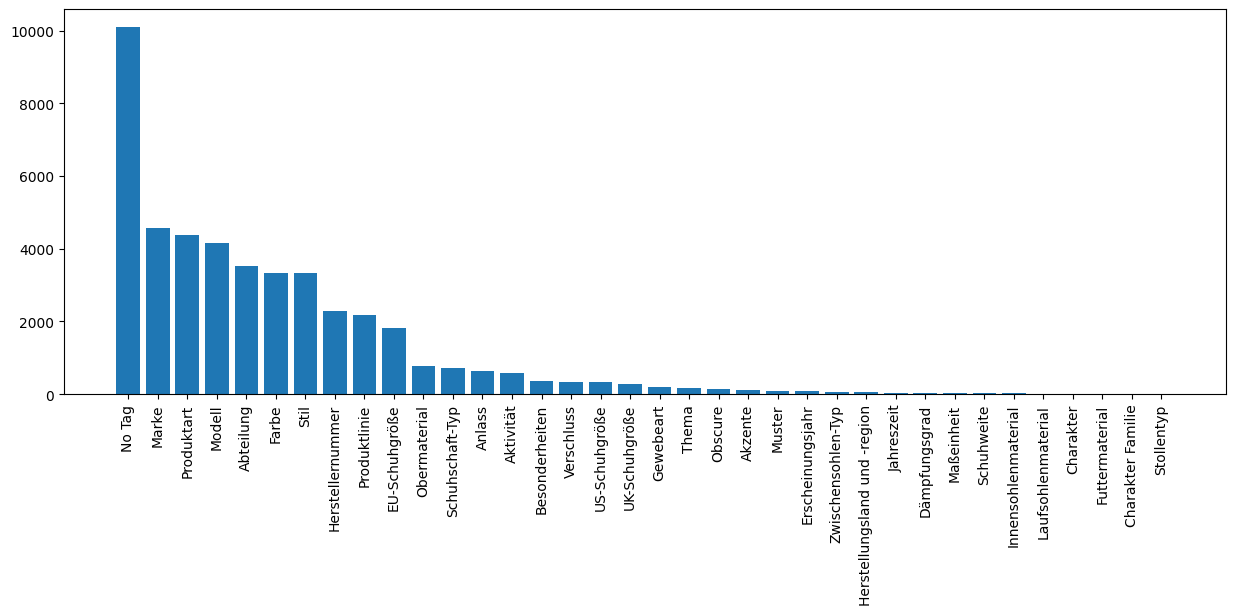

In [ ]:
train_tag_counts = train_ner.groupby("Tag").count()["Token"].sort_values(ascending=False)

fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.bar(train_tag_counts.index, train_tag_counts.values.flatten(), )
plt.xticks(train_tag_counts.index, rotation=90)
plt.show()

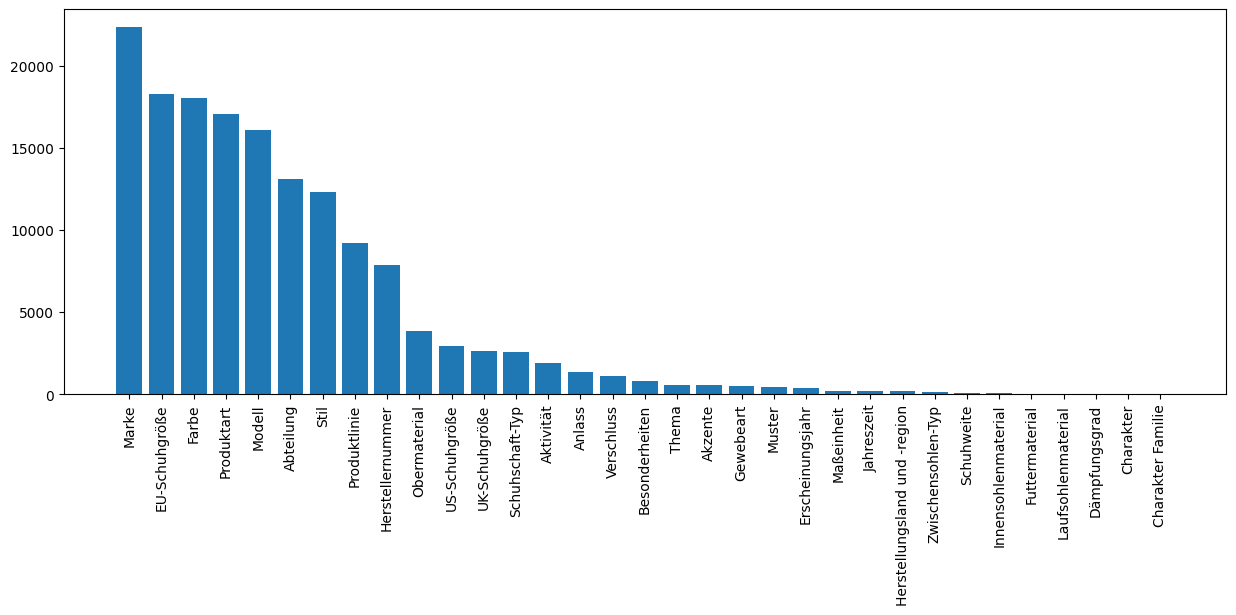

In [ ]:
test_tag_counts = best_submission.groupby("Tag").count()["Token"].sort_values(ascending=False)

fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.bar(test_tag_counts.index, test_tag_counts.values.flatten(), )
plt.xticks(test_tag_counts.index, rotation=90)
plt.show()

In [ ]:
# which tags are most underrepresented?
total_tags_train = train_tag_counts.sum()
total_tags_test = test_tag_counts.sum()

# Normalize the token counts by the total number of tokens in each set
norm_train_tag_counts = train_tag_counts / total_tags_train
norm_test_tag_counts = test_tag_counts / total_tags_test

# Calculate the relative frequency difference between training and test sets
tag_freq_diff = norm_train_tag_counts - norm_test_tag_counts

# Display the tokens that are least represented in the test set compared to the training set (negative to positive)
least_represented_tags = tag_freq_diff.sort_values(ascending=True)
print(least_represented_tags)

Tag
EU-Schuhgröße                  -0.077124
Marke                          -0.042087
Farbe                          -0.042047
Produktart                     -0.012326
US-Schuhgröße                  -0.011385
Modell                         -0.011356
UK-Schuhgröße                  -0.011016
Produktlinie                   -0.010926
Obermaterial                   -0.007870
Abteilung                      -0.006224
Stil                           -0.005300
Akzente                        -0.001026
Muster                         -0.000809
Maßeinheit                     -0.000766
Schuhschaft-Typ                -0.000686
Erscheinungsjahr               -0.000580
Jahreszeit                     -0.000182
Futtermaterial                 -0.000016
Charakter                       0.000084
Herstellernummer                0.000092
Schuhweite                      0.000106
Charakter Familie               0.000134
Laufsohlenmaterial              0.000154
Innensohlenmaterial             0.000220
Herstellungs

In [1]:
least_represented_tags.head(10)

NameError: ignored

What this tells us:
- EU-Schuhgröße
- Marke
- Farbe
- Produktart
- US-Schuhgröße
- Modell
- UK-Schuhgröße
- Produktlinie
- Obermaterial
- Abteilung
- Stil
- Akzente

are the most underrepresented (by an orders of magnitude of the others)

In [ ]:
# key: EDA of training set isn't enough; diff in training and test set is important